# Разработка модели для автоматического обнаружения токсичных комментариев с BERT

Цель данного проекта состоит в разработке модели классификации комментариев на позитивные и негативные с целью обеспечения безопасного и конструктивного обсуждения товаров в интернет-магазине «Викишоп».

Для достижения поставленной цели мы будем использовать набор данных с разметкой о токсичности комментариев. Задача состоит в обучении модели, способной автоматически определять и классифицировать комментарии как позитивные или негативные. Метрика качества F1 должна составлять не менее 0.75.

Разработка такой модели позволит интернет-магазину «Викишоп» эффективно фильтровать токсичные комментарии и обеспечивать безопасное и приятное пользовательское взаимодействие, повышая уровень доверия и комфортности покупательского процесса.

**Описание данных**

**Признак**

- `text` - текст комментария

**Целевой признак**

- `toxic` - метка токсичности 


**Этапы работы**

1. [Обзор данных](#Обзор-данных)
2. [Обучение моделей c TF-IDF и BERT](#Обучение)
3. [Анализ результатов](#Анализ-результатов)
4. [Вывод](#Вывод)

In [29]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re 
import random
import math
import mglearn
import torch
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer 
from tqdm import tqdm
from catboost import CatBoostClassifier
from pymystem3 import Mystem
from wordcloud import WordCloud

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier

from pandarallel import pandarallel
tqdm.pandas(desc="progress") 
pandarallel.initialize(progress_bar = True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
RANDOM_STATE = 42

In [30]:
def clear_text(text):
    """
    Очищает текст от специальных символов и приводит к нижнему регистру.
    
    Аргументы:
    text (str): Исходный текст.

    Возвращает:
    str: Очищенный текст.
    """
    import re
    text = text.lower()
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text) 
    clear_text = " ".join(clear_text.split())
  
    return clear_text



def lemmatize_text(text):
    """
    Лемматизирует текст, удаляет стоп-слова и возвращает обработанный текст.
    (Пришлось костылить функцую из-за некоректной работы Pandarallel с windows)
    
    Аргументы:
    text (str): Исходный текст.

    Возвращает:
    str: Обработанный текст после лемматизации и удаления стоп-слов.
    """
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.corpus import wordnet
    
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text) 
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token.lower() not in stop_words]
    
    return ' '.join(lemmatized_tokens)

## Обзор данных

### Загрузка данных

In [5]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('There is no such file')

In [6]:
display(data.sample(5))
data.info()

,Unnamed: 0,text,toxic
25550,25574,ANTI NORTH EAST INDIA EDITOR,0
157621,157780,1. You are lying. Post the sentence where it s...,1
58683,58749,(as I mentioned above and as WP:ADVOCACY expli...,0
16763,16780,You are right. But it is not actually a bad fa...,0
104686,104783,"""\n\nHow about, US Airways/Aer Lingus Logan Ai...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Появился непонятный Unnamed столбец, избавимся от него.

In [7]:
data.drop(data.columns[0], axis=1, inplace=True)
data.sample(5)

,text,toxic
149166,Such a caricature style is actually also still...,0
74211,"""\n\nIs there some reason why the article list...",0
131204,"""\n\nGeorgy Korniyenko\n\nA proposed deletion ...",0
139350,"Would it not be useful to keep these details, ...",0
6959,"That is interesting about Batman, I think it g...",0


### Проверка на наличие дубликатов

In [8]:
print(f'Количество явных дубликатов: {data.duplicated().sum()}')
print(f'Количество неявных дубликатов: {data["text"].duplicated().sum()}')

Количество явных дубликатов: 0
Количество неявных дубликатов: 0


### Изучение распределения целевого признака

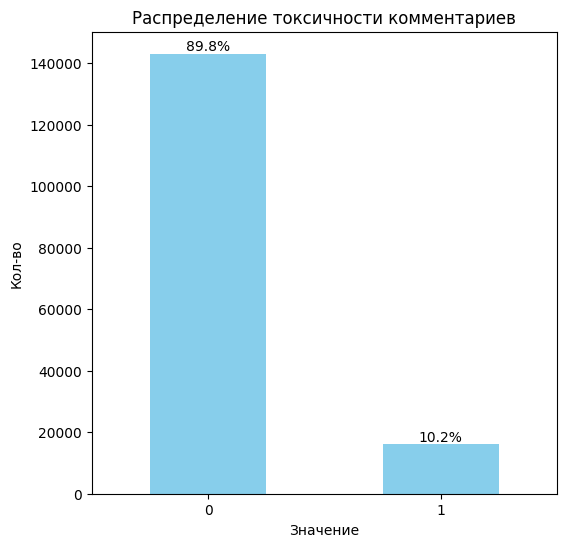

In [9]:
toxic_counts = data['toxic'].value_counts()

percentages = toxic_counts / toxic_counts.sum() * 100


plt.figure(figsize=(6, 6))
bars = toxic_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение токсичности комментариев')
plt.xlabel('Значение')
plt.ylabel('Кол-во')

for i, (count, percentage) in enumerate(zip(toxic_counts, percentages)):
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.show()

**Вывод:**


Мы успешно завершили процесс загрузки данных и провели проверку на наличие дубликатов, которые обнаружены не были. Кроме того, отмечается значительный дисбаланс в целевом признаке(90% к 10%).

## Обучение

### TF-IDF 

**Очистка и лемматизация текса**

In [10]:
data['text'] = data['text'].parallel_apply(clear_text) 
data['lemm_text'] = data['text'].parallel_apply(lemmatize_text)
data.sample(5)

,text,toxic,lemm_text
30704,please explain this edit please explain why yo...,0,please explain edit please explain make revert...
29168,you love satan not cool man and you call yours...,1,love satan cool man call wikipedia editor
26784,disagree i think this article is noteable and ...,0,disagree think article noteable need expansion...
159149,ah good swing on in that case,0,ah good swing case
45285,tone and verification this article seems very ...,0,tone verification article seem promotion witho...


### Визуализация популярности слов для токсичных и нетоксичных комментариев

In [11]:
text_raw_toxic = " ".join(data.loc[data['toxic'] == 1, 'lemm_text'])
text_raw_no_toxic = " ".join(data.loc[data['toxic'] == 0, 'lemm_text'])
wordcloud_toxic = WordCloud().generate(text_raw_toxic)
wordcloud_no_toxic = WordCloud().generate(text_raw_no_toxic)

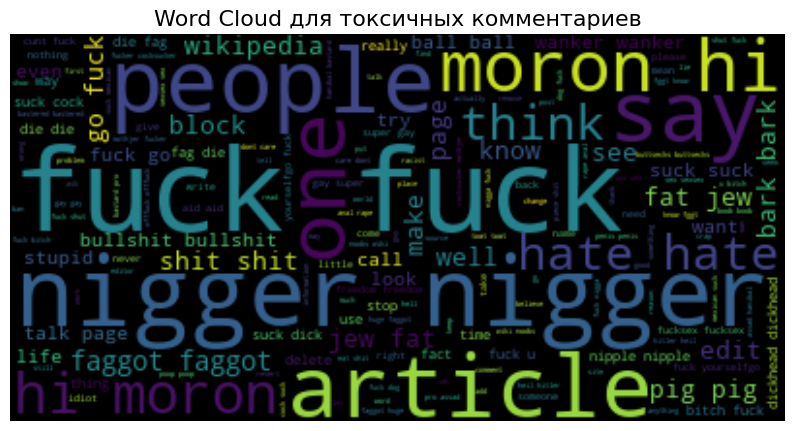

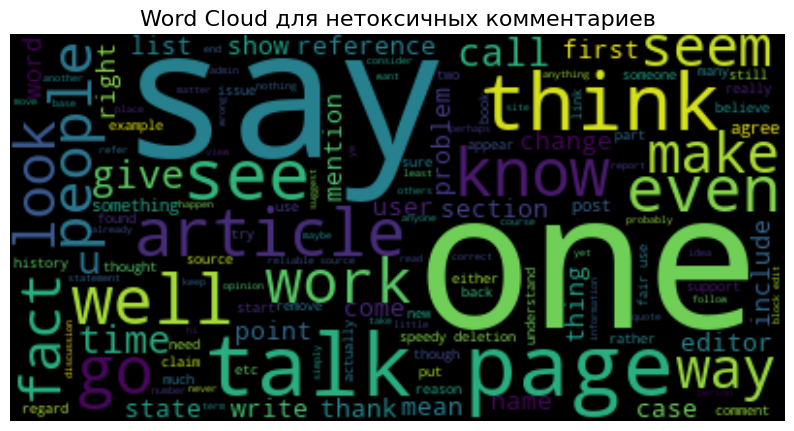

In [12]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud для токсичных комментариев', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_no_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud для нетоксичных комментариев', fontsize=16)
plt.show()

Топ слов для токсичных комментариев:
- fuck
- nigger
- people 
- hate

Топ слов для нетоксичных комментариев:
- one
- say
- page
- talk

**Деление данных на выборки c лематизацией**

In [13]:
features = data['lemm_text']
target = data['toxic']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

**LogisticRegression**

In [14]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('models', model_lr)
])

param_grid_lr = {
     'tfidf__min_df': [1, 2, 3],
     'tfidf__ngram_range': [(1, 1), (1,2)],
     'models__C': [0.01, 0.1, 1, 10],
    },

grid_search_lr = RandomizedSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='f1')
grid_search_lr.fit(features_train, target_train)

best_pipeline_lr = grid_search_lr.best_estimator_
target_predict_train = best_pipeline_lr.predict(features_train)
f1_score_lr = grid_search_lr.best_score_ 

print("F1 LogisticRegression:", f1_score_lr)
print("Лучшая модель:")
print(best_pipeline_lr)

F1 LogisticRegression: 0.7729288596677484
Лучшая модель:
Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                ('models', LogisticRegression(C=10, random_state=42))])


**DecisionTreeClassifier**

In [15]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('models', model_dt)
])

param_grid_dt = {
     'tfidf__min_df': [1, 2, 3], 
     'tfidf__ngram_range': [(1, 1), (1,2)],
     'models__min_samples_split': range(2, 15),
     'models__max_depth': range(2, 15),
    },

grid_search_dt = RandomizedSearchCV(pipeline_dt, param_grid_dt, cv=3, scoring='f1')
grid_search_dt.fit(features_train, target_train)

best_pipeline_dt = grid_search_dt.best_estimator_
target_predict_train = best_pipeline_dt.predict(features_train)
f1_score_dt = grid_search_dt.best_score_ 

print("F1 DecisionTreeClassifier:", f1_score_dt)
print("Лучшая модель:")
print(best_pipeline_dt)

F1 DecisionTreeClassifier: 0.6232616815371491
Лучшая модель:
Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                ('models',
                 DecisionTreeClassifier(max_depth=12, min_samples_split=14,
                                        random_state=42))])


**CatBoostClassifier**

In [17]:
model_catboost = CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, verbose=False)

pipeline_catboost = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('models', model_catboost)
])


param_grid_catboost = {
     'tfidf__min_df': [2], 
     'tfidf__ngram_range': [(1, 1), (1, 2)],
     'models__depth': [2, 4, 6],
     'models__iterations': [40, 50, 70]
}

grid_search_catboost = RandomizedSearchCV(pipeline_catboost, param_grid_catboost, cv=3, scoring='f1')
grid_search_catboost.fit(features_train, target_train)

best_pipeline_catboost = grid_search_catboost.best_estimator_
target_predict_train_catboost = best_pipeline_catboost.predict(features_train)
f1_score_catboost = grid_search_catboost.best_score_


print("F1 CatBoost:", f1_score_catboost)
print("Best model:")
print(best_pipeline_catboost)

F1 CatBoost: 0.7375700034219955
Best model:
Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000019F7F852580>)])


### Изучение коэффициентов лучшей модели TF-IDF

<Figure size 1500x500 with 0 Axes>

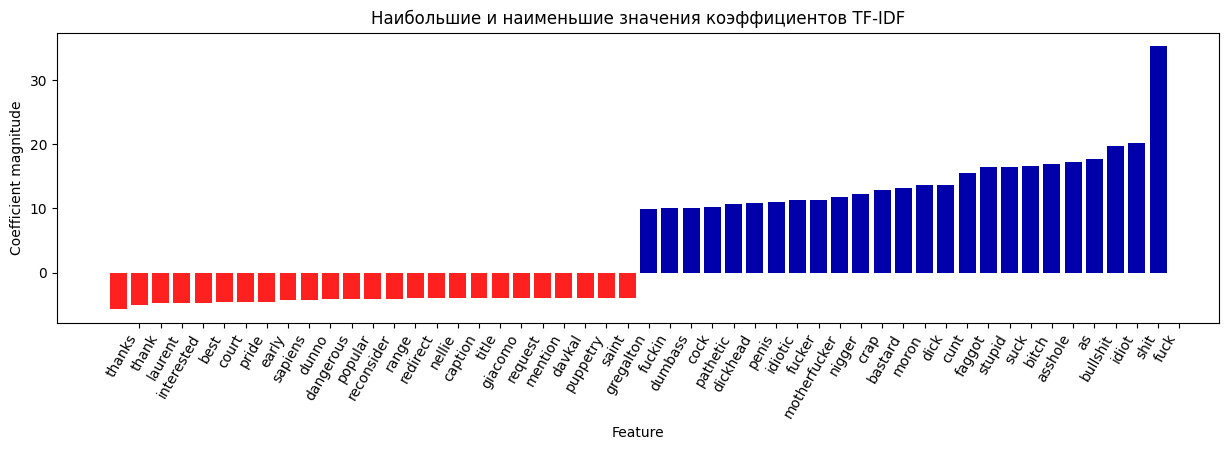

In [16]:
coef_lr = best_pipeline_lr.named_steps['models'].coef_[0]

feature_names = best_pipeline_lr.named_steps['tfidf'].get_feature_names_out()

plt.figure(figsize=(15, 5))
mglearn.tools.visualize_coefficients(coef_lr, feature_names, n_top_features=25)
plt.title('Наибольшие и наименьшие значения коэффициентов TF-IDF')
plt.show();

### BERT

**Преобразование текста**

In [18]:
model_name = "unitary/toxic-bert" 
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [19]:
batch_size = 100

sample_size = int(0.1 * len(data))

sampled_indices = random.sample(list(data.index), sample_size)

sampled_df = data.loc[sampled_indices].reset_index(drop=True)

tokenized = sampled_df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = max(len(x) for x in tokenized)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

num_batches = math.ceil(padded.shape[0] / batch_size)

embeddings = []

for i in tqdm(range(num_batches)):
    start_idx = batch_size * i
    end_idx = min(batch_size * (i + 1), padded.shape[0]) 
    batch = torch.LongTensor(padded[start_idx:end_idx]) 
    attention_mask_batch = torch.LongTensor(attention_mask[start_idx:end_idx])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
 
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [2:32:30<00:00, 57.19s/it]


**Деление данных на выборки для bert**

In [20]:
features = np.concatenate(embeddings)

target = sampled_df['toxic']

features_train_bert, features_valid_bert, target_train_bert, target_valid_bert = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

**LogisticRegression**

In [21]:
model_lr_bert = LogisticRegression(random_state=RANDOM_STATE)

pipeline_lr_bert = Pipeline([
    ('models', model_lr_bert)
])

param_grid_lr_bert = {
     'models__C': [0.01, 0.1, 1, 10],
    },

grid_search_lr_bert = RandomizedSearchCV(pipeline_lr_bert, param_grid_lr_bert, cv=3, scoring='f1', error_score = 'raise')
grid_search_lr_bert.fit(features_train_bert, target_train_bert)

best_pipeline_lr_bert = grid_search_lr_bert.best_estimator_
target_predict_train_bert = best_pipeline_lr_bert.predict(features_train_bert)
f1_score_lr_bert = grid_search_lr_bert.best_score_ 

print("F1 LogisticRegression:", f1_score_lr_bert)
print("Лучшая модель:")
print(best_pipeline_lr_bert)

F1 LogisticRegression: 0.9187359531768525
Лучшая модель:
Pipeline(steps=[('models', LogisticRegression(C=0.01, random_state=42))])


**DecisionTreeClassifier**

In [22]:
model_dt_bert = DecisionTreeClassifier(random_state=RANDOM_STATE)

pipeline_dt_bert = Pipeline([
    ('models', model_dt_bert)
])

param_grid_dt_bert = {
     'models__min_samples_split': range(2, 15),
     'models__max_depth': range(2, 15),
    },

grid_search_dt_bert = RandomizedSearchCV(pipeline_dt_bert, param_grid_dt_bert, cv=3, scoring='f1')
grid_search_dt_bert.fit(features_train_bert, target_train_bert)

best_pipeline_dt_bert = grid_search_dt_bert.best_estimator_
target_predict_train_bert = best_pipeline_dt_bert.predict(features_train_bert)
f1_score_dt_bert = grid_search_dt_bert.best_score_ 

print("F1 DecisionTreeClassifier:", f1_score_dt_bert)
print("Лучшая модель:")
print(best_pipeline_dt_bert)

F1 DecisionTreeClassifier: 0.9030709931437008
Лучшая модель:
Pipeline(steps=[('models',
                 DecisionTreeClassifier(max_depth=3, min_samples_split=8,
                                        random_state=42))])


**CatBoostClassifier**

In [23]:
model_catboost_bert = CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, verbose=False)

pipeline_catboost_bert = Pipeline([
    ('models', model_catboost_bert)
])


param_grid_catboost_bert = {
     'models__depth': [2, 4, 6, 8],
     'models__iterations': [20, 40, 50, 70]
}

grid_search_catboost_bert = RandomizedSearchCV(pipeline_catboost_bert, param_grid_catboost_bert, cv=3, scoring='f1')
grid_search_catboost_bert.fit(features_train_bert, target_train_bert)

best_pipeline_catboost_bert = grid_search_catboost_bert.best_estimator_
target_predict_train_catboost_bert = best_pipeline_catboost_bert.predict(features_train_bert)
f1_score_catboost_bert = grid_search_catboost_bert.best_score_


print("F1 CatBoost:", f1_score_catboost_bert)
print("Best model:")
print(best_pipeline_catboost_bert)

F1 CatBoost: 0.914100668820684
Best model:
Pipeline(steps=[('models',
                 <catboost.core.CatBoostClassifier object at 0x0000019F0ACCA0D0>)])


**Вывод:**

В ходе исследования были проведено тестирование двух видов векторизации текста: TF-IDF и BERT. Для каждого из данных методов векторизации были обучены три модели классификации: LogisticRegression, DecisionTreeClassifier и CatBoostClassifier.

## Анализ результатов

In [24]:
index = ['LogisticRegression_TF_IDF',
         'DecisionTreeClassifier_TF_IDF',
         'CatBoost_TF_IDF',
         'LogisticRegression_BERT',
         'DecisionTreeClassifier_BERT',
         'CatBoost_BERT',
         ]

data = {'F1':[f1_score_lr,
                f1_score_dt,
                f1_score_catboost,
                f1_score_lr_bert,
                f1_score_dt_bert,
                f1_score_catboost_bert,
                ]}

model_rating = pd.DataFrame(data=data, index=index)
model_rating.sort_values(by=['F1'], ascending=False)

,F1
LogisticRegression_BERT,0.918736
CatBoost_BERT,0.914101
DecisionTreeClassifier_BERT,0.903071
LogisticRegression_TF_IDF,0.772929
CatBoost_TF_IDF,0.737570
DecisionTreeClassifier_TF_IDF,0.623262


С учётом полученных результатов можно утверждать, что модель LogisticRegression, применённая с использованием BERT, продемонстрировала наилучшие показатели и сумела удовлетворить требования заказчика, достигнув значения F1-меры выше 0.75.

### Проверка лучшей модели на тестовых данных

In [25]:
target_predict_valid_lr = best_pipeline_lr_bert.predict(features_valid_bert)
f1_valid_lr = f1_score(target_valid_bert, target_predict_valid_lr)

print("F1 на тестовой выборке для LogisticRegression с BERT:", f1_valid_lr)

F1 на тестовой выборке для LogisticRegression с BERT: 0.927070457354759


Согласно результатам на валидационном наборе, наша модель также достигла значений метрики F1 выше 0.75, что подтверждает её эффективность и соответствие требованиям заказчика.

## Выводы

- Мы провели загрузку данных, проверку на дубликаты и обнаружили значительный дисбаланс в целевом признаке (90% к 10%). После тестирования TF-IDF и BERT для векторизации текста, модель LogisticRegression с BERT продемонстрировала наилучшие результаты, достигнув 0.91 F1-меры на тренировочной выборке, что соответствует требованиям заказчика. Подтверждение эффективности так же получено на тестовом наборе данных(0.92).

- Лучшая модель сохранена в переменную `best_pipeline_lr_bert`